In [81]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import anndata as ad
dataset_name = 'K562_single_cell_line'
test_adata = ad.read_h5ad(f"cache/{dataset_name}/de_adata_test.h5ad")
import pickle
import glob

methods = 'txpert-deloss'

pkl_files = glob.glob(f"AAA_results/{dataset_name}/{methods}/*.pkl")
results = pickle.load(open(pkl_files[0], "rb"))

results_df = []


In [82]:
# import pandas as pd
# import numpy as np

# test_perturbations = os.listdir(f'AAA_DEGs/{dataset_name}/txpert')

# train_degs_length = []
# test_degs_length = []

# deg_dir = f'AAA_DEGs/{dataset_name}/true_degs'
# for aa in os.listdir(deg_dir):
    
#     df = pd.read_csv(os.path.join(deg_dir, aa))
#     if aa in test_perturbations:
#         test_degs_length.append(len(df))
#     else:
#         train_degs_length.append(len(df))
# train_degs_length = pd.Series(train_degs_length)
# test_degs_length = pd.Series(test_degs_length)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# train_degs_length.hist(ax=ax[0])
# test_degs_length.hist(ax=ax[1])
# ax[0].set_title('Train DEGs Length')
# ax[1].set_title('Test DEGs Length')
# plt.show()


In [83]:
import os
import pandas as pd

def load_degs_to_uns(adata, deg_dir):
    rank_genes_groups_cov_all = {}
    for aa in os.listdir(deg_dir):
        df = pd.read_csv(os.path.join(deg_dir, aa))
        if len(df) > 5:
            pert_name = df['pert_name'].iloc[0]
            rank_genes_groups_cov_all[pert_name] = df['names'].tolist()
        else:
            rank_genes_groups_cov_all[pert_name] = []
            print(f"No DEGs for {pert_name}")
    adata.uns['rank_genes_groups_cov_all'] = rank_genes_groups_cov_all
    
    
load_degs_to_uns(test_adata, deg_dir=f'AAA_DEGs/{dataset_name}/true_degs')



No DEGs for CPSF1
No DEGs for GTF2A1
No DEGs for NSRP1
No DEGs for NUP85
No DEGs for RNF20
No DEGs for NLE1


In [84]:
from gspp.metrics import log_metrics, compute_metrics

# for DEG
import scanpy as sc
metrics, test_pert_res = compute_metrics(results, test_adata, metric_stage='slow', match_cntr=True)

sign_delta_de500: 100%|█| 272/272 [00:01<00:00, 15
pearson_delta_de50: 100%|█| 272/272 [00:01<00:00, 
sign_delta_de100: 100%|█| 272/272 [00:01<00:00, 17
edist_de100: 100%|█| 272/272 [00:04<00:00, 61.02it
wmae_delta_std_de50: 100%|█| 272/272 [00:01<00:00,
mmd_de500: 100%|█| 272/272 [00:31<00:00,  8.57it/s
wmae_delta_std_de500: 100%|█| 272/272 [00:01<00:00
pearson_de100: 100%|█| 272/272 [00:01<00:00, 159.2
sign_delta_de20: 100%|█| 272/272 [00:01<00:00, 191
wmae_delta_std_de100: 100%|█| 272/272 [00:01<00:00
mmd_de100: 100%|█| 272/272 [00:09<00:00, 27.61it/s
spearman_delta_de100: 100%|█| 272/272 [00:01<00:00
spearman_delta_de20: 100%|█| 272/272 [00:01<00:00,
pearson_delta_de100: 100%|█| 272/272 [00:01<00:00,
pearson_de500: 100%|█| 272/272 [00:01<00:00, 168.0
pearson_delta_de500: 100%|█| 272/272 [00:01<00:00,
mmd_de20: 100%|█| 272/272 [00:03<00:00, 70.13it/s]
pearson_delta_de20: 100%|█| 272/272 [00:01<00:00, 
pearson_de20: 100%|█| 272/272 [00:01<00:00, 169.85
spearman_delta_de500: 100%|█| 2

In [85]:
metrics
# results_df = []
for key, value in test_pert_res.items():
    pert_name = str(key).split('+')[0]
    for k, v in value.items():
        if 'de20' in k or 'de50' in k or 'de100' in k:
            de_gene = k.split('_')[-1]
            metric_name = '_'.join(k.split('_')[:-1])
            results_df.append([methods, pert_name, de_gene, metric_name, v.item()])
        else:
            results_df.append([methods, pert_name, 'all_genes', k, v.item()])
# results_df

## All genes 

In [86]:
# for all genes
from gspp.metrics import log_metrics, compute_metrics
metrics, test_pert_res = compute_metrics(results, test_adata, metric_stage='fast', match_cntr=True) 

pearson: 100%|█| 272/272 [00:01<00:00, 157.44it/s]
spearman_delta: 100%|█| 272/272 [00:01<00:00, 151.
pearson_delta: 100%|█| 272/272 [00:01<00:00, 166.9


In [87]:
result_df = []
for key, value in test_pert_res.items():
    for k, v in value.items():
        pert_name = str(key).split('+')[0]
        metric_name = k
        results_df.append([methods, pert_name, 'all_genes', metric_name, v.item()])
result_df = pd.DataFrame(result_df, columns=['model', 'pert_name', 'genes', 'metric', 'value'])
result_df.to_csv('results_df.csv', index=False)

## Overlap Top DEG

In [88]:
# move to calculate_DEGs.ipynb to calculate top DEG overlap
# we save the DEG results in deg_results_all and deg_results_txpert
import os
import scanpy as sc
def compute_top_DEG_overlap(methods, n_top: int = 100) -> float:
    overlap_scores = {}
	
    for condition in os.listdir(f'AAA_DEGs/{dataset_name}/{methods}'):
        x_df = pd.read_csv(f'AAA_DEGs/{dataset_name}/{methods}/{condition}')
        if x_df.empty:
            continue
        x_df['abs_lfc'] = x_df['logfoldchanges'].abs()
        x_df = x_df.nlargest(n_top, 'abs_lfc')
        x_top_genes = set(x_df['names'].tolist())


        y_df = pd.read_csv(f'AAA_DEGs/{dataset_name}/true_degs/{condition}')
        if y_df.empty:
            continue
        y_df['abs_lfc'] = y_df['logfoldchanges'].abs()
        y_df = y_df.nlargest(n_top, 'abs_lfc')
        y_top_genes = set(y_df['names'].tolist())        
        
        overlap = x_top_genes & y_top_genes
        # print(f"Overlap between {condition} and y: {len(overlap)/n_top}")
        
        intersection = x_top_genes.intersection(y_top_genes)
        union = x_top_genes.union(y_top_genes)
        
        # Jaccard 相似度 = |A ∩ B| / |A ∪ B|
        if len(union) == 0:
            jaccard_similarity = 1.0 # 两个空集视为完全重叠
        else:
            jaccard_similarity = len(intersection) / len(union)
        
        overlap_scores[condition] = jaccard_similarity
    return overlap_scores


In [89]:
methods_name = ['overlap@20', 'overlap@50', 'overlap@100']
overlap_scores_20 = compute_top_DEG_overlap(methods, n_top=20)
overlap_scores_50 = compute_top_DEG_overlap(methods, n_top=50)
overlap_scores_100 = compute_top_DEG_overlap(methods, n_top=100)

In [90]:
# results_df = []
for i, result in enumerate([overlap_scores_20, overlap_scores_50, overlap_scores_100]):
    for key in result:
        results_df.append([methods, key.split('.')[0], methods_name[i], 'overlap', result[key]])

# results_df = pd.DataFrame(results_df, columns=['model', 'pert_name', 'genes', 'metric', 'value'])
# results_df.to_csv('overlap_df.csv', index=False)

## save to folder

In [91]:
import pandas as pd
results_df = pd.DataFrame(results_df, columns=['model', 'pert_name', 'genes', 'metric', 'value'])
save_path = f'AAA_performances/{dataset_name}/{methods}/results_df.csv'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
results_df.to_csv(save_path, index=False)
results_df

,model,pert_name,genes,metric,value
0,txpert-deloss,ACTR8,de500,sign_delta,0.737705
1,txpert-deloss,ACTR8,de50,pearson_delta,0.712157
2,txpert-deloss,ACTR8,de100,sign_delta,0.700000
3,txpert-deloss,ACTR8,de100,edist,1.917878
4,txpert-deloss,ACTR8,de50,wmae_delta_std,4.239866
...,...,...,...,...,...
9243,txpert-deloss,DAD1,overlap@100,overlap,0.000000
9244,txpert-deloss,POLR3C,overlap@100,overlap,0.000000
9245,txpert-deloss,HIRA,overlap@100,overlap,0.000000
9246,txpert-deloss,ARGLU1,overlap@100,overlap,0.000000


In [92]:
import pandas as pd
dataset_name = 'K562_single_cell_line'
txpert_df = pd.read_csv(f"AAA_performances/{dataset_name}/txpert/results_df.csv", sep=',')
txpert_llm_df = pd.read_csv(f"AAA_performances/{dataset_name}/txpert-llm/results_df.csv", sep=',')
control_mean_flow_df = pd.read_csv(f"AAA_performances/{dataset_name}/control-mean-flow/results_df.csv", sep=',')
control_sampling_flow_v5_df = pd.read_csv(f"AAA_performances/{dataset_name}/control-sampling-flow-v5/results_df.csv", sep=',')
random_flow_v5_df = pd.read_csv(f"AAA_performances/{dataset_name}/random-flow-v5/results_df.csv", sep=',')
txpert_deloss_df = pd.read_csv(f"AAA_performances/{dataset_name}/txpert-deloss/results_df.csv", sep=',')
random_flow_scale_df = pd.read_csv(f"AAA_performances/{dataset_name}/random-flow-scale0.05-v4/results_df.csv", sep=',')

In [106]:
# df = pd.concat([txpert_deloss_df, txpert_df, txpert_llm_df, control_mean_flow_df, control_sampling_flow_v5_df, random_flow_v5_df])
df = pd.concat([txpert_deloss_df, txpert_df, random_flow_scale_df])

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_(metrics, df, title_method='metric'):
        
    # 设置为 Set2 调色板，它提供了较浅、较柔和的分类颜色
    sns.set_palette("Paired") 

    # metrics = ['overlap@20', 'overlap@50', 'overlap@100']
    metrics_len = len(metrics)
    
    if metrics_len > 5:
        max_rows = 2 # 最大行数固定为 2
    else:
        max_rows = 1

    # 计算所需的列数 N (向上取整)
    cols = (metrics_len + max_rows - 1) // max_rows 

    # 1. 创建 max_rows (2) 行 cols 列的子图网格
    fig, ax = plt.subplots(max_rows, cols, figsize=(5*cols, 3*max_rows)) 

    # 2. **关键修正：** 将 ax 展平为一维数组，统一访问接口
    #    即使 ax 已经是 1D (如 2行1列时)，flatten 也不会出错。
    ax_flat = ax.flatten()

    # 初始化图例变量
    h, l = None, None

    # ---
    # ## 列优先绘制与图例移除

    for i, metric in enumerate(metrics):
        # **列优先索引计算**：确定当前指标应该对应到展平数组中的哪个索引
        
        # 因为我们使用 ax.flatten()，我们直接使用 i 作为索引，
        # 并在循环结束后隐藏空白子图，实现列优先填充。
        
        current_ax = ax_flat[i]
        
        # 绘制柱状图，使用 Set2 调色板的颜色
        sns.barplot(
            x='genes', 
            y='value', 
            hue='model', 
            data=df[df[title_method] == metric], # metric, perturb_level
            ax=current_ax
        )
        
        # **移除当前子图的图例**
        current_ax.legend_.remove()
        current_ax.set_ylabel('')
        current_ax.set_title(metric)
        # current_ax.set_ylim(0, 0.7)
        
        # **仅在第一次循环时获取图例信息**
        if i == 0:
            h, l = current_ax.get_legend_handles_labels()

    # ---
    # **在 Figure 级别添加统一的图例 (右侧中心)**

    # loc='center right' 和 bbox_to_anchor=(1.03, 0.5) 将图例放置在整个图的右边，不占用子图空间
    fig.legend(
        h, 
        l, 
        title='Model',
        loc='center right', 
        bbox_to_anchor=(1.03, 0.5), 
        ncol=1 
    )

    # 调整子图布局，为右侧的图例腾出空间
    # 将右边界调整到 0.9，留出 10% 空间给图例
    plt.tight_layout(rect=[0, 0, 0.8, 1]) 

    plt.show()

In [108]:
df['metric'].unique()

array(['sign_delta', 'pearson_delta', 'edist', 'wmae_delta_std', 'mmd',
       'pearson', 'spearman_delta', 'overlap'], dtype=object)

## reconstructive metric plot

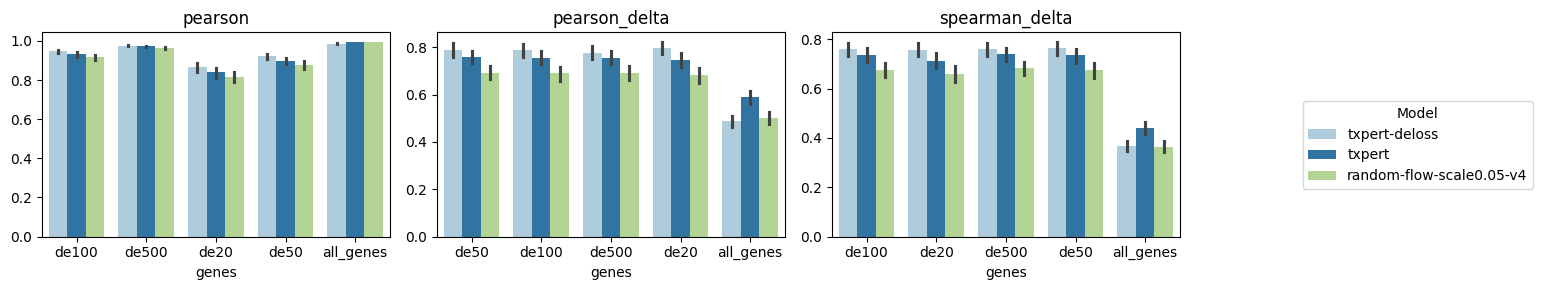

In [109]:
df[df['value'] < 0] = 0
methods_name = ['pearson', 'pearson_delta', 'spearman_delta']
plot_(methods_name, df)

### Generative metric plot

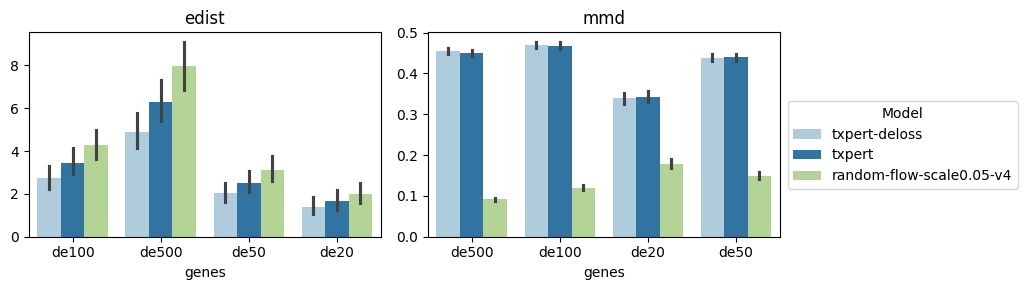

In [110]:
methods_name = ['edist', 'mmd']
plot_(methods_name, df)

### Top N DEG plot

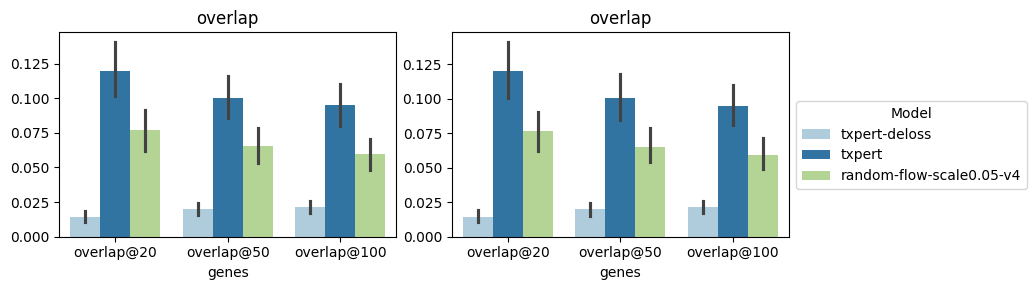

In [111]:
methods_name = ['overlap', 'overlap']
plot_(methods_name, df)

## Perturbation-level wise analysis

In [8]:
perturbation_mapping = pd.read_csv(f"AAA_DEGs/{dataset_name}/perturbations_levels.csv", sep=',')
perturbation_mapping['pert_name'] = perturbation_mapping['pert'].str.split('.').str[0]

In [9]:
perturb_level = []
for pert in df['pert_name']:
    if pert in perturbation_mapping['pert_name'].tolist():
        perturb_level.append(perturbation_mapping[perturbation_mapping['pert_name'] == pert]['level'].values[0])
    else:
        perturb_level.append('unknown')
df['perturb_level'] = perturb_level
df


,model,pert_name,genes,metric,value,perturb_level
0,txpert,ACTR8,de100,pearson,0.925594,l-effect
1,txpert,ACTR8,de20,mmd,0.352488,l-effect
2,0,0,0,0,0.000000,unknown
3,txpert,ACTR8,de50,r2,0.756973,l-effect
4,txpert,ACTR8,de50,mmd,0.471157,l-effect
...,...,...,...,...,...,...
8699,data-flow,DAD1,overlap@100,overlap,0.008065,xs-effect
8700,data-flow,POLR3C,overlap@100,overlap,0.008475,xs-effect
8701,data-flow,HIRA,overlap@100,overlap,0.000000,xs-effect
8702,data-flow,ARGLU1,overlap@100,overlap,0.010101,s-effect


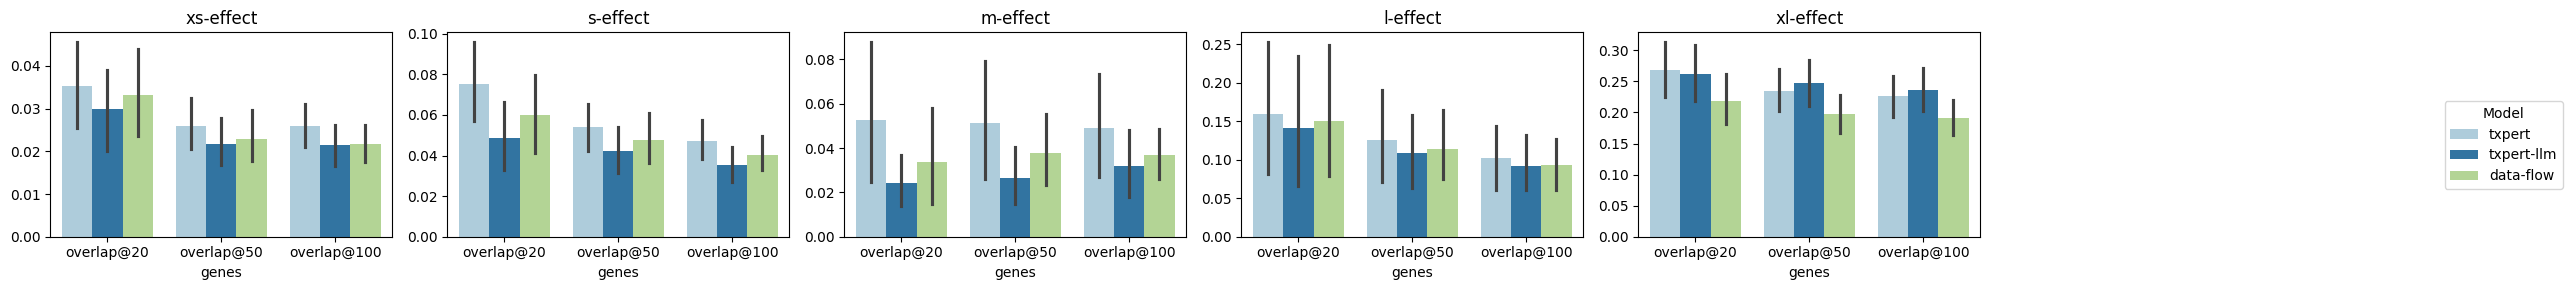

In [10]:
methods_name = ['xs-effect', 's-effect', 'm-effect', 'l-effect', 'xl-effect']
overlap_df = df[df['metric'] == 'overlap']
plot_(methods_name, overlap_df, title_method='perturb_level')


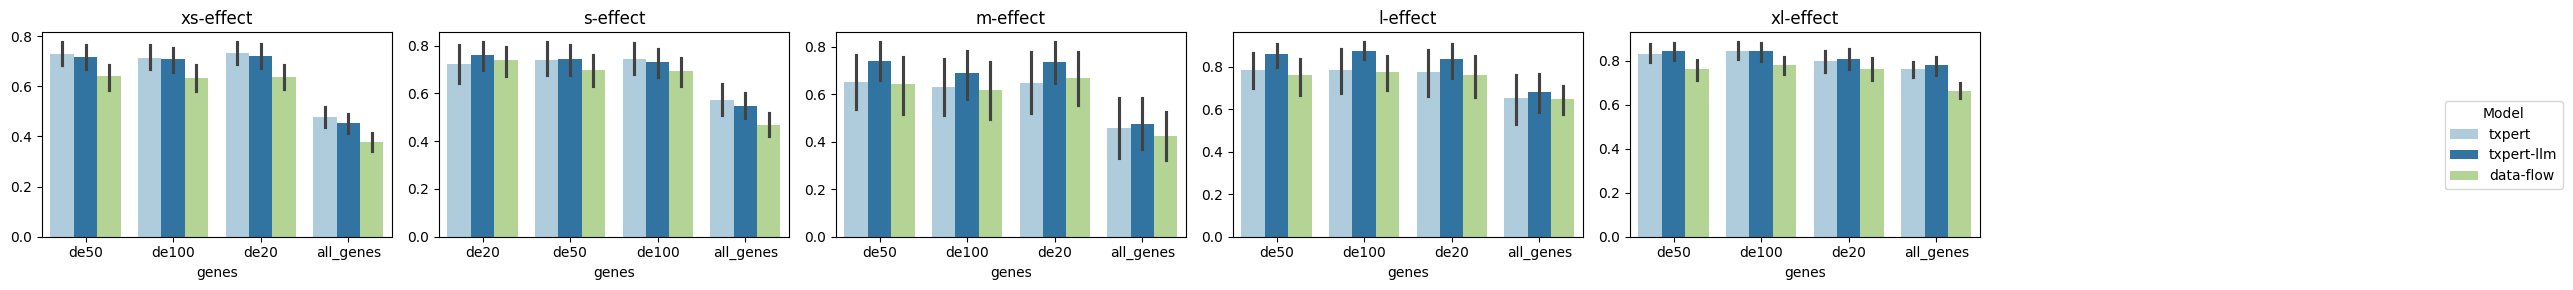

In [11]:
methods_name = ['xs-effect', 's-effect', 'm-effect', 'l-effect', 'xl-effect']
pearson_delta_df = df[df['metric'] == 'pearson_delta']
plot_(methods_name, pearson_delta_df, title_method='perturb_level')

In [12]:
df[df['perturb_level'] == 'l-effect']['pert_name'].unique()

array(['ACTR8', 'BRIX1', 'CPSF4', 'DHX37', 'GRPEL1', 'HGS', 'HSD17B12',
       'MED8', 'NUTF2', 'PAM16', 'POLR1E', 'SART3', 'SCAF1', 'TAF10',
       'TCP1', 'TEX10', 'WDR5'], dtype=object)

In [26]:
df[(df['metric'] == 'pearson_delta') & (df['genes'] == 'de100') & (df['pert_name'] == 'ACTR8')]

,model,pert_name,genes,metric,value,perturb_level
8,txpert,ACTR8,de100,pearson_delta,0.345178,l-effect
8,txpert-llm,ACTR8,de100,pearson_delta,0.787489,l-effect


In [14]:
import matplotlib.pyplot as plt
import pickle
import anndata as ad
import glob

def plot_pearson_scatter(results, control_mean, adata, pert, top_n):
    t = results['truth'][results['pert_cat'] == pert+'+ctrl'].mean(0)
    p = results['pred'][results['pert_cat'] == pert+'+ctrl'].mean(0)
    print(t.shape, p.shape)
    t_delta = t - control_mean
    p_delta = p - control_mean
    pert_deg = pd.read_csv(f'AAA_DEGs/{dataset_name}/true_degs/{pert}.csv')
    deg = pert_deg[:top_n]['names'].tolist()

    for i in range(len(t)):
        if adata.var_names[i] in deg:
            plt.scatter(t_delta[i], p_delta[i], c=t[i], cmap="coolwarm", vmin=-2, vmax=2)
        # else:
            # plt.scatter(t[i], p[i], color='grey', alpha=0.5)
    plt.show()


In [21]:
adata = ad.read_h5ad(f"cache/{dataset_name}/de_adata_test.h5ad")
control_mean = adata[adata.obs.control==1].X.toarray().mean(axis=0)
txpert_results = pickle.load(open(glob.glob(f"AAA_results/{dataset_name}/txpert/*.pkl")[0], "rb"))
txpert_llm_results = pickle.load(open(glob.glob(f"AAA_results/{dataset_name}/txpert-llm/*.pkl")[0], "rb"))
data_flow_results = pickle.load(open(glob.glob(f"AAA_results/{dataset_name}/data-flow/*.pkl")[0], "rb"))


(5000,) (5000,)


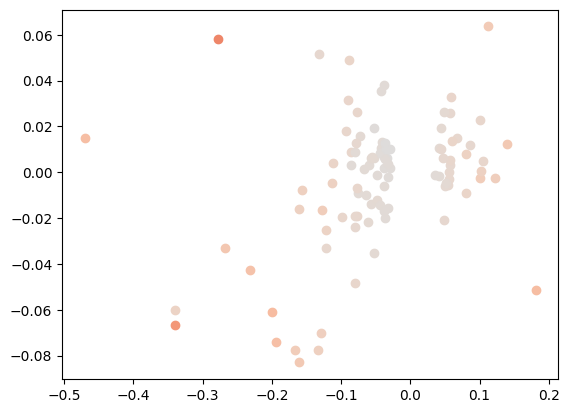

In [22]:
pert = 'ACTR8'

plot_pearson_scatter(txpert_results, control_mean, adata, pert, 100)
# plot_pearson_scatter(results_control, pert, 100)

(5000,) (5000,)


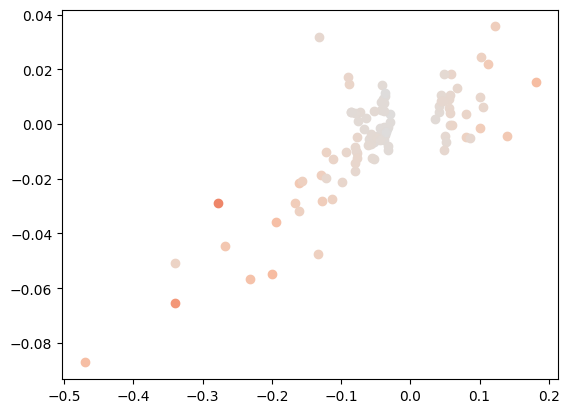

In [23]:
plot_pearson_scatter(txpert_llm_results, control_mean, adata, pert, 100)

(5000,) (5000,)


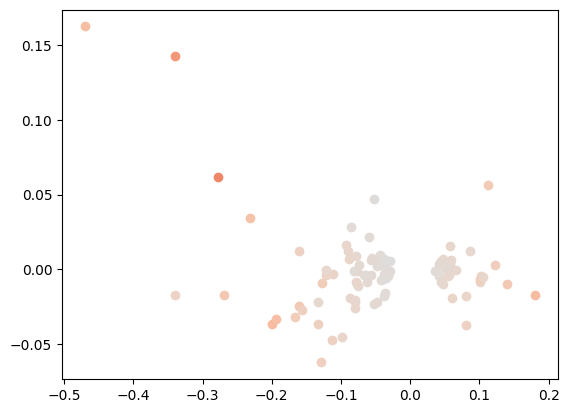

In [24]:
plot_pearson_scatter(data_flow_results, control_mean, adata, pert, 100)